In [110]:
import os
from typing import TypedDict, List, Dict, Any, Annotated

# Manually set the __file__ variable to the notebook's directory
__file__ = os.path.abspath("notebook_name.ipynb")

In [111]:
def load_xml_instructions(filename: str) -> str:
    """
    Load system instructions from 'XML_instructions/filename' if you keep them externally.
    Otherwise, just inline your prompts as strings.
    """
    current_dir = os.path.dirname(os.path.abspath(__file__))
    file_path = os.path.join(current_dir, "XML_instructions", filename)
    with open(file_path, "r", encoding="utf-8") as f:
        return f.read()

In [112]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import (
    AIMessage, 
    HumanMessage,
    SystemMessage,
    BaseMessage
)

# Prompts we will use
layout_prompt = load_xml_instructions("render_layout.xml")
component_prompt = load_xml_instructions("component_content_gen.xml")

# LLM
from langchain_groq import ChatGroq
model = ChatGroq(
    temperature=0,
    model_name="llama-3.3-70b-specdec",
    api_key="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",
    disable_streaming=True
)


In [113]:
import operator
from typing import Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel
from typing import Optional

class Components(BaseModel):
    Components: list[str]

class ReportConfig(BaseModel):
    reportTitle: str
    layout: dict
    numberFormat: Optional[dict]

class ComponentConfig(BaseModel):
    config : dict

class OverallState(TypedDict):
    ReportQuery: str
    ReportMetadata: Annotated[List[Dict[str, Any]], operator.add]
    JsonLayout: dict
    Components: list
    JsonLayoutWithComponentConfig: Annotated[list, operator.add]
    Lists: list
    JsonLists: Annotated[list, operator.add]



In [114]:
def generate_layout(state: OverallState):
    system_instructions = load_xml_instructions("render_layout.xml")
    system_msg = SystemMessage(content=system_instructions)
    user_msg = HumanMessage(content=state["ReportQuery"])
    
    structured_llm = model.with_structured_output(
        ReportConfig,
        method="json_mode",
        include_raw=True
    )
    conversation = [system_msg] + [user_msg]
    print("Conversation:", conversation)
    print("LLM Configuration:", {"stream": False, "response_format": "json"})

    try:
        output = structured_llm.invoke(conversation, stream=False, response_format="json")
    except Exception as e:
        print("Error during LLM invocation:", str(e))
        raise

    parsed_output = output["parsed"].model_dump()

    # Find components
    components = []
    def walk(obj):
        if isinstance(obj, dict):
            if "components" in obj and isinstance(obj["components"], list):
                for c in obj["components"]:
                    components.append(c)
            for v in obj.values():
                walk(v)
        elif isinstance(obj, list):
            for v in obj:
                walk(v)
    walk(parsed_output)
    
    # Output both JsonLayout and Components
    return {"JsonLayout": parsed_output, "Components": components}


In [115]:
from langgraph.constants import Send

def continue_to_components(state: OverallState):
    return [Send("generate_component", {"component": c}) for c in state["Components"]]

def continue_to_lists(state: OverallState):
    return [Send("generate_list_subchart",{"List": l,"ReportMetadata": state["ReportMetadata"] }) for l in state["Lists"]]

In [116]:
class ComponentState(TypedDict):
    component: dict

def generate_component(state: ComponentState):
    component = state["component"]
    ai_description = component.get("AI Generation Description", "None")
    component_id = component.get("id", "NoId")
    
    if(ai_description != "None"):
        system_instructions = load_xml_instructions("component_content_gen.xml")
        system_msg = SystemMessage(content=system_instructions)
        user_msg = HumanMessage(content=ai_description)
        
        structured_llm = model.with_structured_output(
            ComponentConfig,
            method="json_mode",
            include_raw=True
        )
        conversation = [system_msg] + [user_msg]
        output = structured_llm.invoke(conversation, stream=False)
        parsed_output = output["parsed"].model_dump()
    else:
        parsed_output = {}

    # Generate configuration
    generated_config = {
        "id": component_id,
        "generatedConfig": parsed_output
    }

    
        
    return {"JsonLayoutWithComponentConfig": [generated_config]}  # Return as list


In [117]:
def update_json_layout(state: OverallState):
    components_configs = state["JsonLayoutWithComponentConfig"]
    updated_layout = state["JsonLayout"]

    def walk_and_update(layout, configs):
        if isinstance(layout, dict):
            if "components" in layout and isinstance(layout["components"], list):
                for component in layout["components"]:
                    for config in configs:
                        if config["id"] == component.get("id"):
                            component.update(config["generatedConfig"])
            for v in layout.values():
                walk_and_update(v, configs)
        elif isinstance(layout, list):
            for v in layout:
                walk_and_update(v, configs)

    walk_and_update(updated_layout, components_configs)
    return {"JsonLayout": updated_layout}


In [118]:
def gatheruniquelists(state: OverallState):
    """
    Gathers all unique 'lists' definitions from the components in 'JsonLayoutWithComponentConfig'
    and stores them in the 'Lists' and 'JsonLists' fields of the state.
    """
    new_lists = []
    
    for component_config in state.get("JsonLayoutWithComponentConfig", []):

        generated_config = component_config.get("generatedConfig", {})
        config_obj = generated_config.get("config", {})
        comp_lists = config_obj.get("lists", [])

        # Add only unique list definitions
        for list_def in comp_lists:
            if list_def not in new_lists:
                new_lists.append(list_def)

    state["Lists"] = new_lists

    return {
        "Lists": new_lists
    }

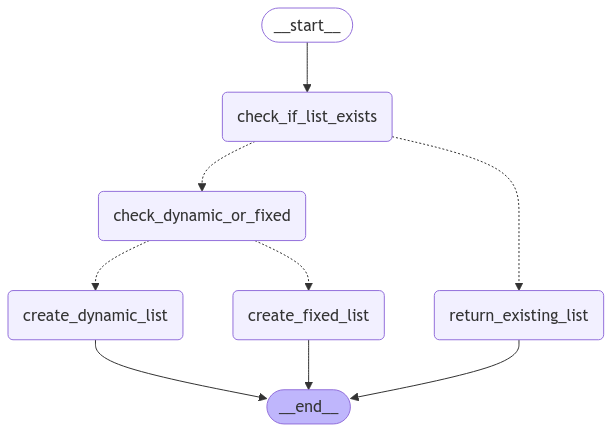

In [119]:
from langgraph.graph import StateGraph, START, END

#########################################################
# 1. Extend the TypedDict for your subchart state
#########################################################
class ListSubchartState(TypedDict):
    """
    Extend your state to include any fields needed
    for checking, creating, or returning a list.
    """
    List: dict              # The raw definition of a list or instructions for how to create it
    listExists: bool        # Whether the list already exists
    listType: str           # 'dynamic' or 'fixed'
    dimensions: List        # Top-level dimensions for the list
    ReportMetadata: Annotated[List[Dict[str, Any]], operator.add]
    JsonLists: List[dict]   # The final generated JSON list(s)
    FinalList: dict         # The actual final list data (if you want it separate from JsonLists)


#########################################################
# 2. Define placeholder nodes
#########################################################

def check_if_list_exists(state: ListSubchartState):
    """
    Placeholder: checks if the list already exists.
    Set 'listExists' in the returned partial state.
    """
   
    # Example logic (replace with real check):
    #    existing = lookup_list_in_db(state["List"].get("list"))
    #    list_exists_flag = existing is not None
    list_exists_flag = False  # Placeholder: always assume it doesn't exist

    return {"listExists": list_exists_flag}


def return_existing_list(state: ListSubchartState):
    """
    Placeholder: if the list already exists, retrieve and return it.
    """
    # Example logic (replace with real retrieval):
    #   existing_list_data = ...
    existing_list_data = {"someExistingList": True}  # Placeholder

    # Update both FinalList & JsonLists if desired
    return {
        "FinalList": existing_list_data,
        "JsonLists": [existing_list_data]
    }

class DynamicOrFixedReply(BaseModel):
    type: str
    dimensions: list

def check_dynamic_or_fixed(state: ListSubchartState):
    """
    Uses an LLM to decide if the list is 'Fixed' or 'Dynamic' and determine
    which top-level dimensions apply to the list.

    Returns:
      {"listType": "...", "dimensionsUsed": [...]}
    """

    current_list = state["List"]
    report_metadata = state["ReportMetadata"]
    top_level_dims = [
        {
            "name": dim["name"],
            "alias": dim["alias"],
            "members": [member["Name"] for member in dim.get("dimensionContent", [])[:3]]  # First three members
        }
        for dim in report_metadata
    ]
    
    dynamic_or_fixed_prompt = load_xml_instructions("dynamic_or_fixed_prompt.xml")

    system_msg = SystemMessage(content=dynamic_or_fixed_prompt)

    user_input = {
        "listObject": current_list,
        "topLevelDimensions": top_level_dims
    }

    user_msg = HumanMessage(content=json.dumps(user_input, indent=2))
        
    structured_llm = model.with_structured_output(
        DynamicOrFixedReply,
        method="json_mode",
        include_raw=True
    )
    conversation = [system_msg] + [user_msg]
    output = structured_llm.invoke(conversation, stream=False)
    parsed_output = output["parsed"].model_dump()

    return {
        "listType": parsed_output["type"],
        "dimensions": parsed_output["dimensions"]
    }

class FixedListReply(BaseModel):
    dimensions: list
    items: List[dict]

def create_fixed_list(state: ListSubchartState):
    """
    Create a fixed list using the LLM and filtered metadata.
    1. Filter the metadata based on the dimensions in state["dimensions"].
    2. Load instructions from fixedlist_prompt.xml as the system message.
    3. Invoke the LLM using structured output to parse the final JSON.
    4. Return {"FinalList": ...} so subsequent nodes can use it.
    """

    # 1. Gather relevant fields from the state
    current_list = state["List"]              # The user’s list definition
    all_metadata = state["ReportMetadata"]    # The full set of dimension metadata
    chosen_dims = state.get("dimensions", []) # The dimension names from check_dynamic_or_fixed

    # 2. Filter the metadata to include only chosen dimensions
    #    This example also limits each dimensionContent to the first 3 members,
    #    just like we did earlier, but adapt as needed.
    filtered_metadata = []
    for dim in all_metadata:
        if dim["name"] in chosen_dims:
            new_dim = {
                "name": dim["name"],
                "alias": dim["alias"],
                "dimensionContent": dim.get("dimensionContent", [])
            }
            filtered_metadata.append(new_dim)

 # 3. Load the fixed list LLM instructions from an XML file
    #    Adjust the path or method to match your environment
    fixedlist_prompt = load_xml_instructions("fixedlist_prompt.xml")  # placeholder function

    # 4. Prepare messages for the LLM
    system_msg = SystemMessage(content=fixedlist_prompt)

    #   Construct a user message that contains:
    #   - The current list definition
    #   - The filtered dimension metadata
    user_input = {
        "listObject": current_list,
        "filteredMetadata": filtered_metadata
    }
    user_msg = HumanMessage(content=json.dumps(user_input, indent=2))

    # 5. Invoke the LLM with structured output
    structured_llm = model.with_structured_output(
        FixedListReply,
        method="json_mode",
        include_raw=True
    )
    conversation = [system_msg, user_msg]
    output = structured_llm.invoke(conversation, stream=False)

    # 6. Parse the LLM’s structured output
    parsed_output = output["parsed"]
    final_list = parsed_output.model_dump()
    print (final_list)
    # 7. Return final state
    return {"JsonLists": [final_list] }

class DynamicListReply(BaseModel):
    dimensions: list
    type: str
    dynamicconfig: dict

def create_dynamic_list(state: ListSubchartState):
    # 1. Gather relevant fields from the state
    current_list = state["List"]              # The user’s list definition
    all_metadata = state["ReportMetadata"]    # The full set of dimension metadata
    chosen_dims = state.get("dimensions", []) # The dimension names from check_dynamic_or_fixed

    # 2. Filter the metadata to include only chosen dimensions
    #    This example also limits each dimensionContent to the first 3 members,
    #    just like we did earlier, but adapt as needed.
    filtered_metadata = []
    for dim in all_metadata:
        if dim["name"] in chosen_dims:
            new_dim = {
                "name": dim["name"],
                "alias": dim["alias"],
                "dimensionContent": dim.get("dimensionContent", [])
            }
            filtered_metadata.append(new_dim)

 # 3. Load the fixed list LLM instructions from an XML file
    #    Adjust the path or method to match your environment
    dynamiclist_prompt = load_xml_instructions("dynamiclist_prompt.xml")  # placeholder function

    # 4. Prepare messages for the LLM
    system_msg = SystemMessage(content=dynamiclist_prompt)

    #   Construct a user message that contains:
    #   - The current list definition
    #   - The filtered dimension metadata
    user_input = {
        "listObject": current_list,
        "filteredMetadata": filtered_metadata
    }
    user_msg = HumanMessage(content=json.dumps(user_input, indent=2))

    # 5. Invoke the LLM with structured output
    structured_llm = model.with_structured_output(
        DynamicListReply,
        method="json_mode",
        include_raw=True
    )
    conversation = [system_msg, user_msg]
    output = structured_llm.invoke(conversation, stream=False)

    # 6. Parse the LLM’s structured output
    parsed_output = output["parsed"]
    final_list = parsed_output.model_dump()
    print (final_list)
    # 7. Return final state
    return {"JsonLists": [final_list] }

#########################################################
# 4. Build the subgraph: define nodes & edges
#########################################################
subgraph = StateGraph(ListSubchartState)

# Add nodes
subgraph.add_node("check_if_list_exists", check_if_list_exists)
subgraph.add_node("return_existing_list", return_existing_list)
subgraph.add_node("check_dynamic_or_fixed", check_dynamic_or_fixed)
subgraph.add_node("create_fixed_list", create_fixed_list)
subgraph.add_node("create_dynamic_list", create_dynamic_list)

# Edges
subgraph.add_edge(START, "check_if_list_exists")

# 4A: Conditional edge from check_if_list_exists
def list_exists_routing(state: ListSubchartState):
    if state.get("listExists") is True:
        return "return_existing_list"
    else:
        return "check_dynamic_or_fixed"

subgraph.add_conditional_edges("check_if_list_exists", list_exists_routing,
                               ["return_existing_list", "check_dynamic_or_fixed"])

# If the list exists, we return it and end
subgraph.add_edge("return_existing_list", END)

# 4B: Conditional edge from check_dynamic_or_fixed
def dynamic_or_fixed_routing(state: ListSubchartState):
    if state.get("listType") == "Dynamic":
        return "create_dynamic_list"
    else:
        return "create_fixed_list"

subgraph.add_conditional_edges("check_dynamic_or_fixed", dynamic_or_fixed_routing,
                               ["create_dynamic_list", "create_fixed_list"])

# If dynamic -> create_dynamic_list ->  END
subgraph.add_edge("create_dynamic_list", END)


# If fixed -> create_fixed_list ->  END
subgraph.add_edge("create_fixed_list", END)

# Compile the subchart
generate_list_subchart = subgraph.compile()

# Visualize in Jupyter, if needed
from IPython.display import Image
Image(generate_list_subchart.get_graph().draw_mermaid_png())


In [120]:
def consolidate_lists_to_layout(state: OverallState):
    """
    Consolidates all the lists generated by the subgraph into the final layout JSON.
    """
    # Initialize the layout if not already present
    if "JsonLayout" not in state or state["JsonLayout"] is None:
        state["JsonLayout"] = {}

    # Ensure a 'Lists' child exists in JsonLayout
    if "Lists" not in state["JsonLayout"]:
        state["JsonLayout"]["lists"] = []

    # Gather all generated lists from the subgraph
    generated_lists = state.get("JsonLists", [])
    state["JsonLayout"]["lists"].extend(generated_lists)

    return {"JsonLayout": state["JsonLayout"]}

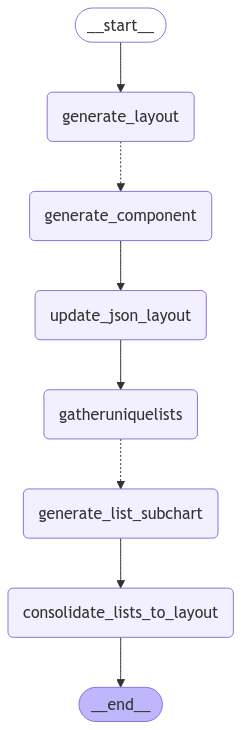

In [121]:
# Main graph
graph = StateGraph(OverallState)

graph.add_node("generate_layout", generate_layout)
graph.add_node("generate_component", generate_component)
graph.add_node("update_json_layout", update_json_layout)
graph.add_node("gatheruniquelists", gatheruniquelists)
graph.add_node("generate_list_subchart", generate_list_subchart)  # Subchart
graph.add_node("consolidate_lists_to_layout", consolidate_lists_to_layout)  # New node

# Define edges
graph.add_edge(START, "generate_layout")
graph.add_conditional_edges("generate_layout", continue_to_components, ["generate_component"])
graph.add_edge("generate_component", "update_json_layout")
graph.add_edge("update_json_layout", "gatheruniquelists")
graph.add_conditional_edges("gatheruniquelists", continue_to_lists, ["generate_list_subchart"])
graph.add_edge("generate_list_subchart", "consolidate_lists_to_layout")
graph.add_edge("consolidate_lists_to_layout", END)

# Compile the main graph
app = graph.compile()

# Visualize the graph
Image(app.get_graph().draw_mermaid_png())


In [122]:
from IPython.display import display, Markdown
import json

state = OverallState(
    # ReportQuery="Create a report showing the profit and loss in a table comparing actuals to budget. Next to the table I want to see a chart with 12 periods comparing Actuals to Budget for the current selected row in the table. Below the chart I want to see a small table breaking down the current selected line in to the product dimension.",
    ReportQuery="Create a report showing the profit and loss in a table comparing actuals to budget.",
    ReportMetadata=[{"name":"Category","alias":"Category","order":3,"default":"Actuals","visible":True,"dimensionContent":[{"ID":1,"Name":"Actuals"},{"ID":2,"Name":"Budget"}]},{"name":"Year","alias":"Year","order":1,"default":2023,"visible":True,"dimensionContent":[{"ID":1,"Name":2022},{"ID":2,"Name":2023},{"ID":3,"Name":2024}]},{"name":"Period","alias":"Period","order":2,"default":"p12 - december","visible":True,"dimensionContent":[{"ID":1,"Name":"p01 - january","ParentId":13},{"ID":2,"Name":"p02 - february","ParentId":13},{"ID":3,"Name":"p03 - march","ParentId":13},{"ID":4,"Name":"p04 - april","ParentId":14},{"ID":5,"Name":"p05 - may","ParentId":14},{"ID":6,"Name":"p06 - june","ParentId":14},{"ID":7,"Name":"p07 - july","ParentId":15},{"ID":8,"Name":"p08 - august","ParentId":15},{"ID":9,"Name":"p09 - september","ParentId":15},{"ID":10,"Name":"p10 - october","ParentId":16},{"ID":11,"Name":"p11 - november","ParentId":16},{"ID":12,"Name":"p12 - december","ParentId":16},{"ID":13,"Name":"Q1","ParentId":17},{"ID":14,"Name":"Q2","ParentId":17},{"ID":15,"Name":"Q3","ParentId":17},{"ID":16,"Name":"Q4","ParentId":17},{"ID":17,"Name":"Full Year","ParentId":{}}]},{"name":"View","alias":"View","order":2,"default":"Periodic","visible":True,"dimensionContent":[{"ID":1,"Name":"Periodic"},{"ID":2,"Name":"YTD"}]},{"name":"Account","alias":"Account","order":6,"default":"Income","visible":False,"dimensionContent":[{"ID":1,"Name":"Net Profit","ParentId":{},"Valuation":"positive"},{"ID":2,"Name":"Profit before taxes","ParentId":1,"Valuation":"positive"},{"ID":3,"Name":"EBITDA","ParentId":2,"Valuation":"positive"},{"ID":4,"Name":"Gross margin","ParentId":3,"Valuation":"positive"},{"ID":5,"Name":"Income","ParentId":4,"Valuation":"positive"},{"ID":6,"Name":"COGS","ParentId":4,"Valuation":"negative"},{"ID":7,"Name":"Operating Costs","ParentId":3,"Valuation":"negative"},{"ID":8,"Name":"Advertising & Marketing","ParentId":7,"Valuation":"negative"},{"ID":9,"Name":"Data Subscriptions","ParentId":8,"Valuation":"negative"},{"ID":10,"Name":"Marketing Contractors","ParentId":8,"Valuation":"negative"},{"ID":11,"Name":"Marketing SaaS Solutions","ParentId":8,"Valuation":"negative"},{"ID":12,"Name":"PR & Promotion","ParentId":8,"Valuation":"negative"},{"ID":13,"Name":"Website","ParentId":8,"Valuation":"negative"},{"ID":14,"Name":"Legal & Professional Services","ParentId":7,"Valuation":"negative"},{"ID":15,"Name":"Accounting","ParentId":14,"Valuation":"negative"},{"ID":16,"Name":"Professional Fees","ParentId":14,"Valuation":"negative"},{"ID":17,"Name":"Office Supplies & Software","ParentId":7,"Valuation":"negative"},{"ID":18,"Name":"Office Equipment","ParentId":17,"Valuation":"negative"},{"ID":19,"Name":"Saas Admin","ParentId":17,"Valuation":"negative"},{"ID":20,"Name":"SaaS Communication & Productivity","ParentId":17,"Valuation":"negative"},{"ID":21,"Name":"Virtual Office","ParentId":17,"Valuation":"negative"},{"ID":22,"Name":"Payroll Expenses","ParentId":7,"Valuation":"negative"},{"ID":23,"Name":"Contractors","ParentId":22,"Valuation":"negative"},{"ID":24,"Name":"Travel","ParentId":7,"Valuation":"negative"},{"ID":25,"Name":"Travel-Airline","ParentId":24,"Valuation":"negative"},{"ID":26,"Name":"Travel-Lodging","ParentId":24,"Valuation":"negative"},{"ID":27,"Name":"Travel-Meals","ParentId":24,"Valuation":"negative"},{"ID":28,"Name":"Travel-Other","ParentId":24,"Valuation":"negative"},{"ID":29,"Name":"Travel-Taxi","ParentId":24,"Valuation":"negative"},{"ID":30,"Name":"Meals & Entertainment","ParentId":24,"Valuation":"negative"},{"ID":31,"Name":"Miscellaneous","ParentId":7,"Valuation":"negative"},{"ID":32,"Name":"Bank Charges & Fees","ParentId":31,"Valuation":"negative"},{"ID":33,"Name":"Rent & Lease","ParentId":31,"Valuation":"negative"},{"ID":34,"Name":"Phone & Internet","ParentId":31,"Valuation":"negative"},{"ID":35,"Name":"Professional Development","ParentId":31,"Valuation":"negative"},{"ID":36,"Name":"Taxes & Licenses","ParentId":31,"Valuation":"negative"},{"ID":37,"Name":"Other Expenses","ParentId":2,"Valuation":"negative"},{"ID":38,"Name":"Charitable Contributions","ParentId":37,"Valuation":"negative"},{"ID":39,"Name":"Management Fee Payout","ParentId":1,"Valuation":"negative"},{"ID":101,"Name":"Investments","ParentId":{},"Valuation":"positive"},{"ID":102,"Name":"Portfolio ARR","ParentId":{},"Valuation":"positive"}]},{"name":"AnalyticalDim1","alias":"Product","order":7,"default":"TotalProduct","visible":False,"dimensionContent":[{"ID":1,"Name":"TotalProduct","ParentID":{}},{"ID":2,"Name":"CFOTech Fund","ParentID":1},{"ID":3,"Name":"OnPLan SPV","ParentID":1},{"ID":4,"Name":"NoProduct","ParentID":1}]},{"name":"AnalyticalDim2","alias":"Investment","order":8,"default":"TotalInvestment","visible":False,"dimensionContent":[{"ID":1,"Name":"FinTechCore","ParentID":11},{"ID":2,"Name":"CFO Insights","ParentID":11},{"ID":3,"Name":"ProfitWave","ParentID":11},{"ID":4,"Name":"BudgetSphere","ParentID":11},{"ID":5,"Name":"LedgerScope","ParentID":11},{"ID":6,"Name":"CashTrackr","ParentID":11},{"ID":7,"Name":"AccrualBase","ParentID":11},{"ID":8,"Name":"RevBeam","ParentID":11},{"ID":9,"Name":"CapitalFlow","ParentID":11},{"ID":10,"Name":"ExpenseNode","ParentID":11},{"ID":11,"Name":"TotalInvestment","ParentID":{}},{"ID":12,"Name":"NoInvestment","ParentID":11}]},{"name":"Entity","alias":"Entity","order":0,"default":"Born Capital Total","visible":True,"dimensionContent":[{"ID":1,"Name":"Total Born Capital","ParentId":{}}]}],
    JsonLayout={}
)

result_state = app.invoke(state)

if "JsonLayoutWithComponentConfig" in result_state:
    # display(Markdown(f"**Layout JSON**:\n```json\n{json.dumps(result_state['JsonLayout'], indent=2)}\n```"))
    display(result_state['JsonLayout'])
else:
    display(Markdown("**No Layout JSON Generated**"))

Conversation: [SystemMessage(content='<task>\n\t<overview>\n\t\tYour task is to output a json config file for a financial report configuration in JSON format based on the user\'s instructions. \n\t\tThe user provides an existing JSON configuration template and describes the kind of report he wants. \n\t</overview>\n\t<guidelines>\n\t\t<instructionsForGeneratingModifications>\n\t\t\t<instruction>**Understand the User\'s Instructions**: Carefully read the user\'s request to identify the required changes.</instruction>\n\t\t\t<instruction>**Follow the jsonStructure**: See the section jsonStructure for a detailed overview of how the JSON file should be structured</instruction>\n\t\t\t<instruction>**Use the examples**: Use the examples to understand what kind of user queries should lead to certain results, use this for your creative process</instruction>\n\t\t\t<instruction>**Add a createDescription attribute to each list. The createDescription will be used by antoher chatbot that will crea

{'reportTitle': 'Profit and Loss - Analysis',
 'layout': {'gridColumns': {'sm': 1, 'md': 1, 'lg': 8},
  'rows': [{'columns': [{'colSpan': {'sm': 1, 'md': 1, 'lg': 8},
      'components': [{'id': 'C1',
        'type': 'ReportTable',
        'title': 'Profit and Loss Statement',
        'AI Generation Description': 'A table showing the profit and loss statement on the rows and comparing actuals to budget with a variance bar on the columns.',
        'config': {'selectRow': True,
         'firstColumnWidth': 250,
         'lists': [{'listReference': 'rowsList',
           'list': 'ProfitAndLossAccounts',
           'createDescription': 'Create a list named ProfitAndLossAccounts that includes all the accounts related to profit and loss statement, such as revenues, cost of goods sold, operating expenses, etc.'},
          {'listReference': 'columnsList',
           'list': 'ActualsBudgetVariance%VarianceBar',
           'createDescription': 'Create a list named ActualsBudgetVariance%Varianc

In [123]:
from IPython.display import display, Markdown
import json

state = ListSubchartState(
  List={
    "listObject": {
      "listReference": "categoryList",
      "list": "12periods",
      "createDescription": "Create a rolling 12 month lists starting from current period"
    },
  },
  ReportMetadata=[{"name":"Category","alias":"Category","order":3,"default":"Actuals","visible":True,"dimensionContent":[{"ID":1,"Name":"Actuals"},{"ID":2,"Name":"Budget"}]},{"name":"Year","alias":"Year","order":1,"default":2023,"visible":True,"dimensionContent":[{"ID":1,"Name":2022},{"ID":2,"Name":2023},{"ID":3,"Name":2024}]},{"name":"Period","alias":"Period","order":2,"default":"p12 - december","visible":True,"dimensionContent":[{"ID":1,"Name":"p01 - january","ParentId":13},{"ID":2,"Name":"p02 - february","ParentId":13},{"ID":3,"Name":"p03 - march","ParentId":13},{"ID":4,"Name":"p04 - april","ParentId":14},{"ID":5,"Name":"p05 - may","ParentId":14},{"ID":6,"Name":"p06 - june","ParentId":14},{"ID":7,"Name":"p07 - july","ParentId":15},{"ID":8,"Name":"p08 - august","ParentId":15},{"ID":9,"Name":"p09 - september","ParentId":15},{"ID":10,"Name":"p10 - october","ParentId":16},{"ID":11,"Name":"p11 - november","ParentId":16},{"ID":12,"Name":"p12 - december","ParentId":16},{"ID":13,"Name":"Q1","ParentId":17},{"ID":14,"Name":"Q2","ParentId":17},{"ID":15,"Name":"Q3","ParentId":17},{"ID":16,"Name":"Q4","ParentId":17},{"ID":17,"Name":"Full Year","ParentId":{}}]},{"name":"View","alias":"View","order":2,"default":"Periodic","visible":True,"dimensionContent":[{"ID":1,"Name":"Periodic"},{"ID":2,"Name":"YTD"}]},{"name":"Account","alias":"Account","order":6,"default":"Income","visible":False,"dimensionContent":[{"ID":1,"Name":"Net Profit","ParentId":{},"Valuation":"positive"},{"ID":2,"Name":"Profit before taxes","ParentId":1,"Valuation":"positive"},{"ID":3,"Name":"EBITDA","ParentId":2,"Valuation":"positive"},{"ID":4,"Name":"Gross margin","ParentId":3,"Valuation":"positive"},{"ID":5,"Name":"Income","ParentId":4,"Valuation":"positive"},{"ID":6,"Name":"COGS","ParentId":4,"Valuation":"negative"},{"ID":7,"Name":"Operating Costs","ParentId":3,"Valuation":"negative"},{"ID":8,"Name":"Advertising & Marketing","ParentId":7,"Valuation":"negative"},{"ID":9,"Name":"Data Subscriptions","ParentId":8,"Valuation":"negative"},{"ID":10,"Name":"Marketing Contractors","ParentId":8,"Valuation":"negative"},{"ID":11,"Name":"Marketing SaaS Solutions","ParentId":8,"Valuation":"negative"},{"ID":12,"Name":"PR & Promotion","ParentId":8,"Valuation":"negative"},{"ID":13,"Name":"Website","ParentId":8,"Valuation":"negative"},{"ID":14,"Name":"Legal & Professional Services","ParentId":7,"Valuation":"negative"},{"ID":15,"Name":"Accounting","ParentId":14,"Valuation":"negative"},{"ID":16,"Name":"Professional Fees","ParentId":14,"Valuation":"negative"},{"ID":17,"Name":"Office Supplies & Software","ParentId":7,"Valuation":"negative"},{"ID":18,"Name":"Office Equipment","ParentId":17,"Valuation":"negative"},{"ID":19,"Name":"Saas Admin","ParentId":17,"Valuation":"negative"},{"ID":20,"Name":"SaaS Communication & Productivity","ParentId":17,"Valuation":"negative"},{"ID":21,"Name":"Virtual Office","ParentId":17,"Valuation":"negative"},{"ID":22,"Name":"Payroll Expenses","ParentId":7,"Valuation":"negative"},{"ID":23,"Name":"Contractors","ParentId":22,"Valuation":"negative"},{"ID":24,"Name":"Travel","ParentId":7,"Valuation":"negative"},{"ID":25,"Name":"Travel-Airline","ParentId":24,"Valuation":"negative"},{"ID":26,"Name":"Travel-Lodging","ParentId":24,"Valuation":"negative"},{"ID":27,"Name":"Travel-Meals","ParentId":24,"Valuation":"negative"},{"ID":28,"Name":"Travel-Other","ParentId":24,"Valuation":"negative"},{"ID":29,"Name":"Travel-Taxi","ParentId":24,"Valuation":"negative"},{"ID":30,"Name":"Meals & Entertainment","ParentId":24,"Valuation":"negative"},{"ID":31,"Name":"Miscellaneous","ParentId":7,"Valuation":"negative"},{"ID":32,"Name":"Bank Charges & Fees","ParentId":31,"Valuation":"negative"},{"ID":33,"Name":"Rent & Lease","ParentId":31,"Valuation":"negative"},{"ID":34,"Name":"Phone & Internet","ParentId":31,"Valuation":"negative"},{"ID":35,"Name":"Professional Development","ParentId":31,"Valuation":"negative"},{"ID":36,"Name":"Taxes & Licenses","ParentId":31,"Valuation":"negative"},{"ID":37,"Name":"Other Expenses","ParentId":2,"Valuation":"negative"},{"ID":38,"Name":"Charitable Contributions","ParentId":37,"Valuation":"negative"},{"ID":39,"Name":"Management Fee Payout","ParentId":1,"Valuation":"negative"},{"ID":101,"Name":"Investments","ParentId":{},"Valuation":"positive"},{"ID":102,"Name":"Portfolio ARR","ParentId":{},"Valuation":"positive"}]},{"name":"AnalyticalDim1","alias":"Product","order":7,"default":"TotalProduct","visible":False,"dimensionContent":[{"ID":1,"Name":"TotalProduct","ParentID":{}},{"ID":2,"Name":"CFOTech Fund","ParentID":1},{"ID":3,"Name":"OnPLan SPV","ParentID":1},{"ID":4,"Name":"NoProduct","ParentID":1}]},{"name":"AnalyticalDim2","alias":"Investment","order":8,"default":"TotalInvestment","visible":False,"dimensionContent":[{"ID":1,"Name":"FinTechCore","ParentID":11},{"ID":2,"Name":"CFO Insights","ParentID":11},{"ID":3,"Name":"ProfitWave","ParentID":11},{"ID":4,"Name":"BudgetSphere","ParentID":11},{"ID":5,"Name":"LedgerScope","ParentID":11},{"ID":6,"Name":"CashTrackr","ParentID":11},{"ID":7,"Name":"AccrualBase","ParentID":11},{"ID":8,"Name":"RevBeam","ParentID":11},{"ID":9,"Name":"CapitalFlow","ParentID":11},{"ID":10,"Name":"ExpenseNode","ParentID":11},{"ID":11,"Name":"TotalInvestment","ParentID":{}},{"ID":12,"Name":"NoInvestment","ParentID":11}]},{"name":"Entity","alias":"Entity","order":0,"default":"Born Capital Total","visible":True,"dimensionContent":[{"ID":1,"Name":"Total Born Capital","ParentId":{}}]}]
)

# result_state = generate_list_subchart.invoke(state)
# display(result_state["JsonLists"])